# Parameterized IQP circuits for Bars and Stripes 

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import random
import iqpopt as iqp
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic
import jax
import jax.numpy as jnp

In [3]:
def label_simple_bars_stripes(size):
    type_choice = np.random.choice(['bars','stripes'])
    pattern = np.zeros((size,size))
    place = np.random.choice([0,1,2,3])
    if type_choice == 'bars':
        label = int(0)
        pattern[:,place] = np.ones(4)
    elif type_choice == 'stripes':
        label = int(1)
        pattern[place,:] = np.ones(4)
    return [label] + np.concatenate(pattern).astype(int).tolist()


#Generamos dataset y set para comparacion posterior
label_ctrain = [] 
bar = set()
stripe = set() 
for k in range(2750):
    pattern = label_simple_bars_stripes(4)
    label_ctrain.append(pattern)
    string = ''.join(map(str,pattern[1:]))
    if pattern[0] == 1:
        stripe.add(string)
    elif pattern[0] == 0:
        bar.add(string)

In [8]:
#Circuito IQP
n_qubits = 17  #qb 0 es el qubit decision

simple_gates = [[[0,1,2,3,4]],[[0,5,6,7,8]],[[0,9,10,11,12]],[[0,13,14,15,16]],
                [[0,1,5,9,13]],[[0,2,6,10,14]],[[0,3,7,11,15]],[[0,4,8,12,16]]]

simple_gates2 =  [[[1,2,3,4]],[[5,6,7,8]],[[9,10,11,12]],[[13,14,15,16]],
                [[1,5,9,13]],[[2,6,10,14]],[[3,7,11,15]],[[4,8,12,16]]] 

altsimple_gates = [[[0,1],[1,2,3,4]],[[0,5],[5,6,7,8]],[[0,9],[9,10,11,12]],[[0,13],[13,14,15,16]],
                [[0,1],[1,5,9,13]],[[0,2],[2,6,10,14]],[[0,3],[3,7,11,15]],[[0,4],[4,8,12,16]]] 

cgates = []

for d in range(17):
    #for k in altsimple_gates:
        #cgates.append(k)
    for k in simple_gates:
        cgates.append(k)
    for j in simple_gates2:
        cgates.append(j) 

csimple = iqp.IqpSimulator(n_qubits,cgates,device ='lightning.qubit')

3.307189138830738


Training Progress: 100%|██████████| 700/700 [03:08<00:00,  3.71it/s, loss=0.002095, elapsed time=0.28, total time=189] 

Training has not converged after 700 steps


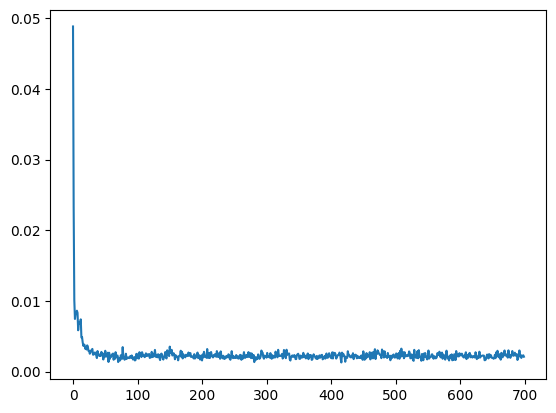

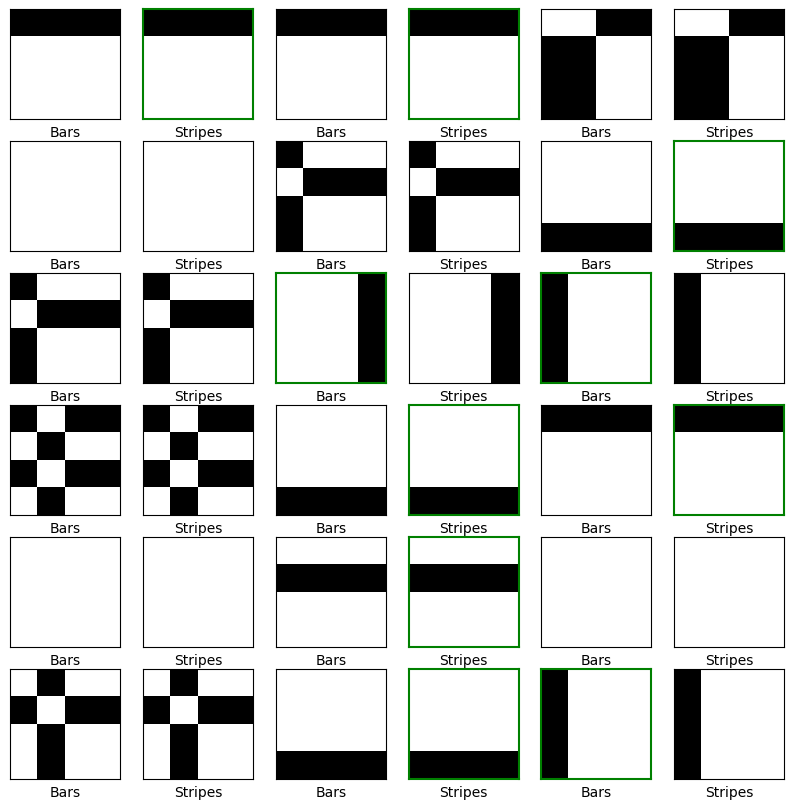

In [ ]:
#Train
sigma = median_heuristic(label_ctrain) * 1.25 #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)

params_init = jax.random.normal(key, (len(cgates),)) * (1 / jnp.sqrt(n_qubits))
#params_init = jnp.ones(len(simple_gates)) *  (1 / jnp.sqrt(n_qubits))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": csimple,
    "ground_truth": jnp.array(label_ctrain), # samples from ground truth distribution
    "sigma": sigma,
    "n_ops": 2500,
    "n_samples": 2500,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.01)
trainer.train(n_iters= 700,loss_kwargs=loss_kwarg)
clabel_params = trainer.final_params
plt.plot(trainer.losses)
plt.show() 

#Plots de resultados
j = 1
plt.figure(figsize=[10, 10])
for i in range(36):
    check = False
    if i % 2 == 0:
        res = iqp.IqpSimulator(n_qubits,cgates,device ='lightning.qubit')
        sam = res.sample(clabel_params,shots = 1)
        lab = 'Bars'
        im = sam[1:]
        sam_str = ''.join(map(str,im))
        if sam_str in bar:
            check = True
        
        
    elif i % 2 == 1:
        res = iqp.IqpSimulator(n_qubits,cgates,init_gates=[[[0]]],init_coefs=[np.pi],device ='lightning.qubit')
        sam = res.sample(clabel_params,shots = 1)
        lab = 'Stripes'
        sam_str = ''.join(map(str,im))
        if sam_str in stripe:
            check = True
    
    ax = plt.subplot(6, 6, j)
    j += 1
    plt.imshow(np.reshape(im, [4, 4]), cmap="gray_r")
    if check == True:
        plt.setp(ax.spines.values(), color="red", linewidth=1.5)
    plt.xlabel(lab)
    plt.xticks([])
    plt.yticks([])

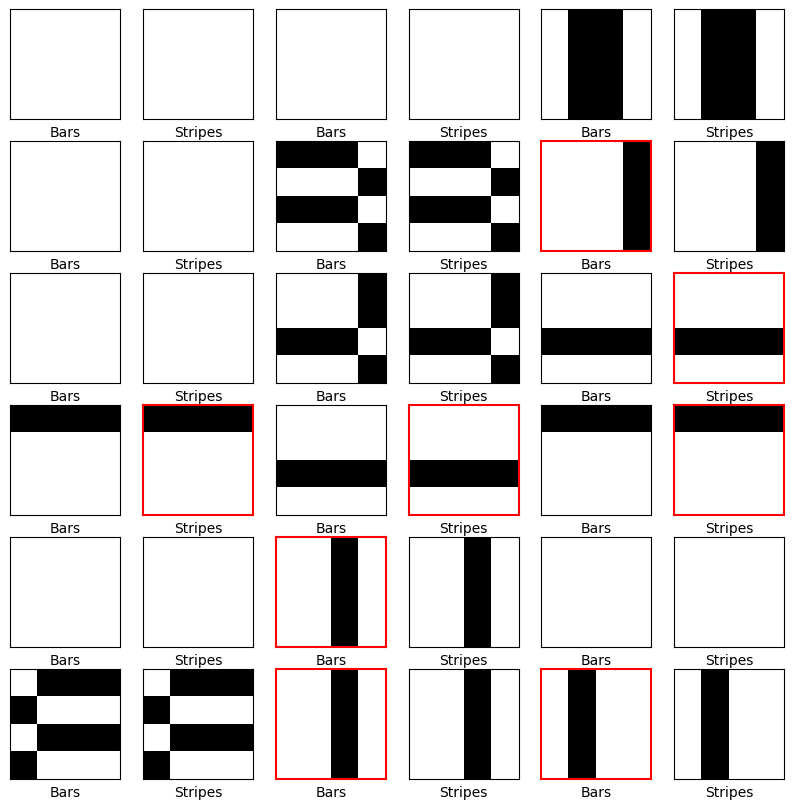

In [14]:
#Plots de resultados
j = 1
plt.figure(figsize=[10, 10])
for i in range(36):
    check = False
    if i % 2 == 0:
        res = iqp.IqpSimulator(n_qubits,cgates,device ='lightning.qubit')
        sam = res.sample(clabel_params,shots = 1)
        lab = 'Bars'
        im = sam[1:]
        sam_str = ''.join(map(str,im))
        if sam_str in bar:
            check = True
        
        
    elif i % 2 == 1:
        res = iqp.IqpSimulator(n_qubits,cgates,init_gates=[[[0]]],init_coefs=[np.pi],device ='lightning.qubit')
        sam = res.sample(clabel_params,shots = 1)
        lab = 'Stripes'
        sam_str = ''.join(map(str,im))
        if sam_str in stripe:
            check = True
    
    ax = plt.subplot(6, 6, j)
    j += 1
    plt.imshow(np.reshape(im, [4, 4]), cmap="gray_r")
    if check == True:
        plt.setp(ax.spines.values(), color="red", linewidth=1.5)
    plt.xlabel(lab)
    plt.xticks([])
    plt.yticks([])